In [1]:
# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')
    
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import model_selection
# Show pipeline as plot
from sklearn import set_config
set_config(display='diagram')
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from keras import Model
from keras.layers import Input, Reshape, Dense, Dropout, Concatenate, Embedding, Convolution1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.utils import plot_model
import seaborn as sns
import math as math

Using TensorFlow backend.


# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.head()

,Unnamed: 0,Unnamed: 0.1,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,...,Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy,age_group,age_category
0,0,0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy,40-50,adult
1,1,1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy,70-80,senior
2,2,2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy,70-80,senior
3,3,3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy,40-50,adult
4,4,4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy,60-70,senior


In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'CRC', 'Crohns disease', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape
abundance_indices = range(0, MatrixData.shape[1])

In [7]:
ClinicalNumeric_vars = ['BMI (kg/m²)', 'FBG (mmol/L)', 'TRIG (mmol/L)', 'LDLC (mmol/L)','CHOL (mmol/L)', 'HDLC (mmol/L)']
# ClinicalNumeric_vars = ['BMI (kg/m²)']
ClinicalData_numeric = SampleMeta[ClinicalNumeric_vars]
ClinicalData_numeric.rename(columns={'BMI (kg/m²)':'BMI', 'FBG (mmol/L)':'FBG', 'TRIG (mmol/L)':'TRIG', 'LDLC (mmol/L)':'LDLC','CHOL (mmol/L)':'CHOL', 'HDLC (mmol/L)':'HDLC'}, inplace=True)
# Manipulate and convert to float
ClinicalData_numeric["BMI"].replace({'not recorded':np.nan, '<23':'22.99', 'Mismatch for Sample ID':np.nan, '<25':'24.99'}, inplace=True)
ClinicalData_numeric["BMI"].astype(float)
ClinicalData_numeric["FBG"].astype(float)
ClinicalData_numeric["TRIG"].astype(float)
ClinicalData_numeric["LDLC"].astype(float)
ClinicalData_numeric["HDLC"].astype(float)
ClinicalData_numeric = ClinicalData_numeric.fillna(-99)
ClinicalNumeric_vars = ClinicalData_numeric.columns.tolist()
ClinicalCategorical_vars = ['Gender', 'Geographical Region or Population','Physical Exercise (Yes/No/Hours)','Smoking (Yes/No)', 
                            'Residence (Rural/Urban)','Use of milk or milk products (Yes/No/Sometimes)',
                            'Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan)','Alcohol Consumption (Yes/No)', 
                            'Diet1','Intervention for study (Diet)', 'Intervention for study (medication)', 'age_category']
# ClinicalCategorical_vars = ['Gender', 'Geographical Region or Population','Physical Exercise (Yes/No/Hours)','Smoking (Yes/No)', 
#                             'Residence (Rural/Urban)','Use of milk or milk products (Yes/No/Sometimes)',
#                             'Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan)','Alcohol Consumption (Yes/No)', 
#                             'Diet1','Intervention for study (Diet)', 'Intervention for study (medication)', 'age_category']
# ClinicalCategorical_vars = ['Gender', 'age_category']
ClinicalData_categorical = SampleMeta[ClinicalCategorical_vars]
ClinicalData_categorical.rename(columns={'Geographical Region or Population':'GRoP', 
                                         'Physical Exercise (Yes/No/Hours)':'Phys_Ex', 
                                         'Smoking (Yes/No)':'Smoking',
                                         'Residence (Rural/Urban)':'Residence',
                                         'Use of milk or milk products (Yes/No/Sometimes)':'milk',
                                         'Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan)':'meat',
                                         'Alcohol Consumption (Yes/No)':'alcohol',
                                         'Intervention for study (Diet)':'Diet2', 
                                         'Intervention for study (medication)':'medication'}, inplace=True)
# Manipulate and make data consistant..
ClinicalData_categorical["Gender"].replace({'not recorded':np.nan, 'Mismatch for Sample ID':np.nan, 'female':'F', 'male':'M'}, inplace=True)
## Replace NaN with string missing
ClinicalData_categorical = ClinicalData_categorical.fillna("missing")
ClinicalCategorical_vars = ClinicalData_categorical.columns.tolist()

In [8]:
ClinicalData_numeric

,BMI,FBG,TRIG,LDLC,CHOL,HDLC
0,22.58,4.5,1.41,5.24,7.25,0.55
1,24.03,7.53,1.14,1.54,2.53,0.58
2,27.55,7.49,-99,-99,-99.00,-99
3,23.62,14.56,2.85,1.19,2.68,0.63
4,24.44,4.61,1.75,4.8,7.47,1.31
...,...,...,...,...,...,...
3231,-99,-99,-99,-99,-99.00,-99
3232,-99,-99,-99,-99,-99.00,-99
3233,-99,-99,-99,-99,-99.00,-99
3234,-99,-99,-99,-99,-99.00,-99


In [9]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [11]:
cat_sizes = {}
cat_embsizes = {}
for cat_var in ClinicalCategorical_vars:
    cat_sizes[cat_var] = ClinicalData_categorical[cat_var].nunique()
    cat_embsizes[cat_var] = min(50, cat_sizes[cat_var]//2+1)
print( f"cat_sizes={cat_sizes}\ncat_embsizes={cat_embsizes}" )

cat_sizes={'Gender': 3, 'GRoP': 31, 'Phys_Ex': 7, 'Smoking': 5, 'Residence': 3, 'milk': 2, 'meat': 4, 'alcohol': 6, 'Diet1': 6, 'Diet2': 2, 'medication': 2, 'age_category': 5}
cat_embsizes={'Gender': 2, 'GRoP': 16, 'Phys_Ex': 4, 'Smoking': 3, 'Residence': 2, 'milk': 2, 'meat': 3, 'alcohol': 4, 'Diet1': 4, 'Diet2': 2, 'medication': 2, 'age_category': 3}


In [47]:
inputMicrobiome = Input(shape=(903,))
inputClinNum = Input(shape=(len(ClinicalNumeric_vars),))
inputClinCat = Input(shape=(len(ClinicalCategorical_vars),))

microb = Dense(400, activation='relu')(inputMicrobiome)
# microb = Dropout(0.5)(microb)
microb = Dense(100, activation='relu')(microb)
# microb = Dropout(0.5)(microb)
microb = Dense(60, activation='relu')(microb)

clinnum = Dense(20, activation='relu')(inputClinNum)
clinnum = Dense(10, activation='relu')(clinnum)

clin_inputs = []
clin_concat = []

for cat_var in ClinicalCategorical_vars:
    clin_i = Input(shape=(1,), name=cat_var)
    clin_inputs.append( clin_i )
    clin_i = Embedding(cat_sizes[cat_var]+1, cat_embsizes[cat_var], input_length=1)(clin_i)
    clin_i = Reshape((cat_embsizes[cat_var],))(clin_i)
    clin_concat.append(clin_i)

# Concatenate Separate Steps
combined = Concatenate()([microb, clinnum]+clin_concat)
full_connected_layer = Dense(400, activation="relu")(combined)
# full_connected_layer = Dropout(0.5)(full_connected_layer)
full_connected_layer = Dense(100, activation="relu")(full_connected_layer)
# full_connected_layer = Dropout(0.5)(full_connected_layer)
full_connected_layer = Dense(10, activation="relu")(full_connected_layer)
output = Dense(1, activation="sigmoid")(full_connected_layer)

model = Model(inputs=[inputMicrobiome, inputClinNum]+clin_inputs, outputs=output)
# define loss and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
clin_data_arrays = []
for cat_var in ClinicalCategorical_vars:
    ohe = OrdinalEncoder()
    ohe.fit(ClinicalData_categorical[cat_var].to_numpy().reshape(-1, 1))
    clin_data_arrays.append( ohe.transform( ClinicalData_categorical[cat_var].to_numpy().reshape(-1, 1) ) )    

In [58]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 903)          0                                            
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 400)          361600      input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
Gender (InputLayer)             (None, 1)            0                                            
____________________________________________________________________________________________

In [15]:
# plot_model(model, to_file="model.png", show_shapes=True)

# Define and Train Model

In [49]:
# random seed here deals with model initialization
MyTrainer = Trainer(model = model, verbose=0, scale_X = False, use_pca = False)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, metrics.balanced_accuracy_score, test_frac=0.40)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [50]:
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

In [51]:
big_X  = [MatrixData, ClinicalData_numeric.to_numpy()]+clin_data_arrays
# big_X  = [MatrixData]+clin_data_arrays
MyMultiTrainTester.train(big_X, y, 
                         use_indices=True, do_validation=True, 
                         class_weight={0:100, 1:1}, epochs=50, batch_size=128)

Running for split 1 of 5
Train on 1331 samples, validate on 718 samples
Epoch 1/50
1331/1331 [==============================] - 1s 1ms/step - loss: 12.7768 - accuracy: 0.2299 - val_loss: 6.0861 - val_accuracy: 0.1532
Epoch 2/50
1331/1331 [==============================] - 0s 92us/step - loss: 4.4953 - accuracy: 0.1638 - val_loss: 3.0918 - val_accuracy: 0.1532
Epoch 3/50
1331/1331 [==============================] - 0s 88us/step - loss: 3.6885 - accuracy: 0.1638 - val_loss: 2.1332 - val_accuracy: 0.1532
Epoch 4/50
1331/1331 [==============================] - 0s 88us/step - loss: 3.4445 - accuracy: 0.1638 - val_loss: 2.3642 - val_accuracy: 0.1532
Epoch 5/50
1331/1331 [==============================] - 0s 91us/step - loss: 3.3772 - accuracy: 0.1638 - val_loss: 1.9144 - val_accuracy: 0.1532
Epoch 6/50
1331/1331 [==============================] - 0s 87us/step - loss: 3.1905 - accuracy: 0.1638 - val_loss: 2.3232 - val_accuracy: 0.1532
Epoch 7/50
1331/1331 [==============================] - 0s

Epoch 6/50
1331/1331 [==============================] - 0s 89us/step - loss: 3.2025 - accuracy: 0.1796 - val_loss: 3.1073 - val_accuracy: 0.1462
Epoch 7/50
1331/1331 [==============================] - 0s 88us/step - loss: 3.1243 - accuracy: 0.1833 - val_loss: 2.6971 - val_accuracy: 0.1518
Epoch 8/50
1331/1331 [==============================] - 0s 89us/step - loss: 3.0746 - accuracy: 0.1841 - val_loss: 2.4201 - val_accuracy: 0.1560
Epoch 9/50
1331/1331 [==============================] - 0s 89us/step - loss: 2.8503 - accuracy: 0.2066 - val_loss: 2.3880 - val_accuracy: 0.1699
Epoch 10/50
1331/1331 [==============================] - 0s 86us/step - loss: 2.6134 - accuracy: 0.2382 - val_loss: 1.7271 - val_accuracy: 0.2159
Epoch 11/50
1331/1331 [==============================] - 0s 87us/step - loss: 2.3522 - accuracy: 0.3133 - val_loss: 2.2657 - val_accuracy: 0.2201
Epoch 12/50
1331/1331 [==============================] - 0s 88us/step - loss: 2.1798 - accuracy: 0.3809 - val_loss: 2.1191 - val

1331/1331 [==============================] - 0s 90us/step - loss: 1.7885 - accuracy: 0.5440 - val_loss: 2.3021 - val_accuracy: 0.3329
Epoch 12/50
1331/1331 [==============================] - 0s 91us/step - loss: 1.9431 - accuracy: 0.5447 - val_loss: 3.8850 - val_accuracy: 0.2577
Epoch 13/50
1331/1331 [==============================] - 0s 89us/step - loss: 2.1487 - accuracy: 0.5515 - val_loss: 2.3917 - val_accuracy: 0.3426
Epoch 14/50
1331/1331 [==============================] - 0s 93us/step - loss: 1.5281 - accuracy: 0.6086 - val_loss: 1.4034 - val_accuracy: 0.5056
Epoch 15/50
1331/1331 [==============================] - 0s 87us/step - loss: 1.3360 - accuracy: 0.6890 - val_loss: 1.6032 - val_accuracy: 0.4875
Epoch 16/50
1331/1331 [==============================] - 0s 88us/step - loss: 0.9960 - accuracy: 0.7453 - val_loss: 1.5848 - val_accuracy: 0.5418
Epoch 17/50
1331/1331 [==============================] - 0s 88us/step - loss: 0.8267 - accuracy: 0.7964 - val_loss: 1.7975 - val_accurac

1331/1331 [==============================] - 0s 89us/step - loss: 1.5401 - accuracy: 0.6153 - val_loss: 1.6317 - val_accuracy: 0.4290
Epoch 17/50
1331/1331 [==============================] - 0s 92us/step - loss: 1.1305 - accuracy: 0.7333 - val_loss: 1.3249 - val_accuracy: 0.4972
Epoch 18/50
1331/1331 [==============================] - 0s 88us/step - loss: 0.8442 - accuracy: 0.8122 - val_loss: 1.2276 - val_accuracy: 0.5585
Epoch 19/50
1331/1331 [==============================] - 0s 93us/step - loss: 0.6435 - accuracy: 0.8512 - val_loss: 1.1001 - val_accuracy: 0.6240
Epoch 20/50
1331/1331 [==============================] - 0s 90us/step - loss: 0.6007 - accuracy: 0.8678 - val_loss: 1.5122 - val_accuracy: 0.5097
Epoch 21/50
1331/1331 [==============================] - 0s 90us/step - loss: 0.4955 - accuracy: 0.8798 - val_loss: 1.2601 - val_accuracy: 0.6476
Epoch 22/50
1331/1331 [==============================] - 0s 91us/step - loss: 0.3078 - accuracy: 0.9354 - val_loss: 1.3076 - val_accurac

1331/1331 [==============================] - 0s 93us/step - loss: 0.9600 - accuracy: 0.8039 - val_loss: 2.0172 - val_accuracy: 0.5223
Epoch 22/50
1331/1331 [==============================] - 0s 90us/step - loss: 1.5490 - accuracy: 0.6687 - val_loss: 2.9833 - val_accuracy: 0.3969
Epoch 23/50
1331/1331 [==============================] - 0s 92us/step - loss: 1.3834 - accuracy: 0.7062 - val_loss: 2.3284 - val_accuracy: 0.4276
Epoch 24/50
1331/1331 [==============================] - 0s 93us/step - loss: 1.0164 - accuracy: 0.7536 - val_loss: 1.4769 - val_accuracy: 0.5780
Epoch 25/50
1331/1331 [==============================] - 0s 94us/step - loss: 0.6995 - accuracy: 0.8430 - val_loss: 1.3951 - val_accuracy: 0.5975
Epoch 26/50
1331/1331 [==============================] - 0s 92us/step - loss: 0.4332 - accuracy: 0.9038 - val_loss: 1.3864 - val_accuracy: 0.6532
Epoch 27/50
1331/1331 [==============================] - 0s 92us/step - loss: 0.2710 - accuracy: 0.9361 - val_loss: 1.2214 - val_accurac

In [52]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.957983,train
1,0.966245,train
2,0.971616,train
3,0.992891,train
4,0.938525,train
0,0.478250,test
1,0.476039,test
2,0.495801,test
3,0.506563,test
4,0.498218,test


<AxesSubplot:xlabel='stage', ylabel='score'>

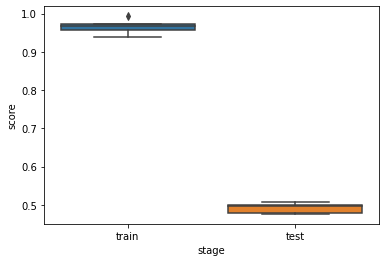

In [53]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

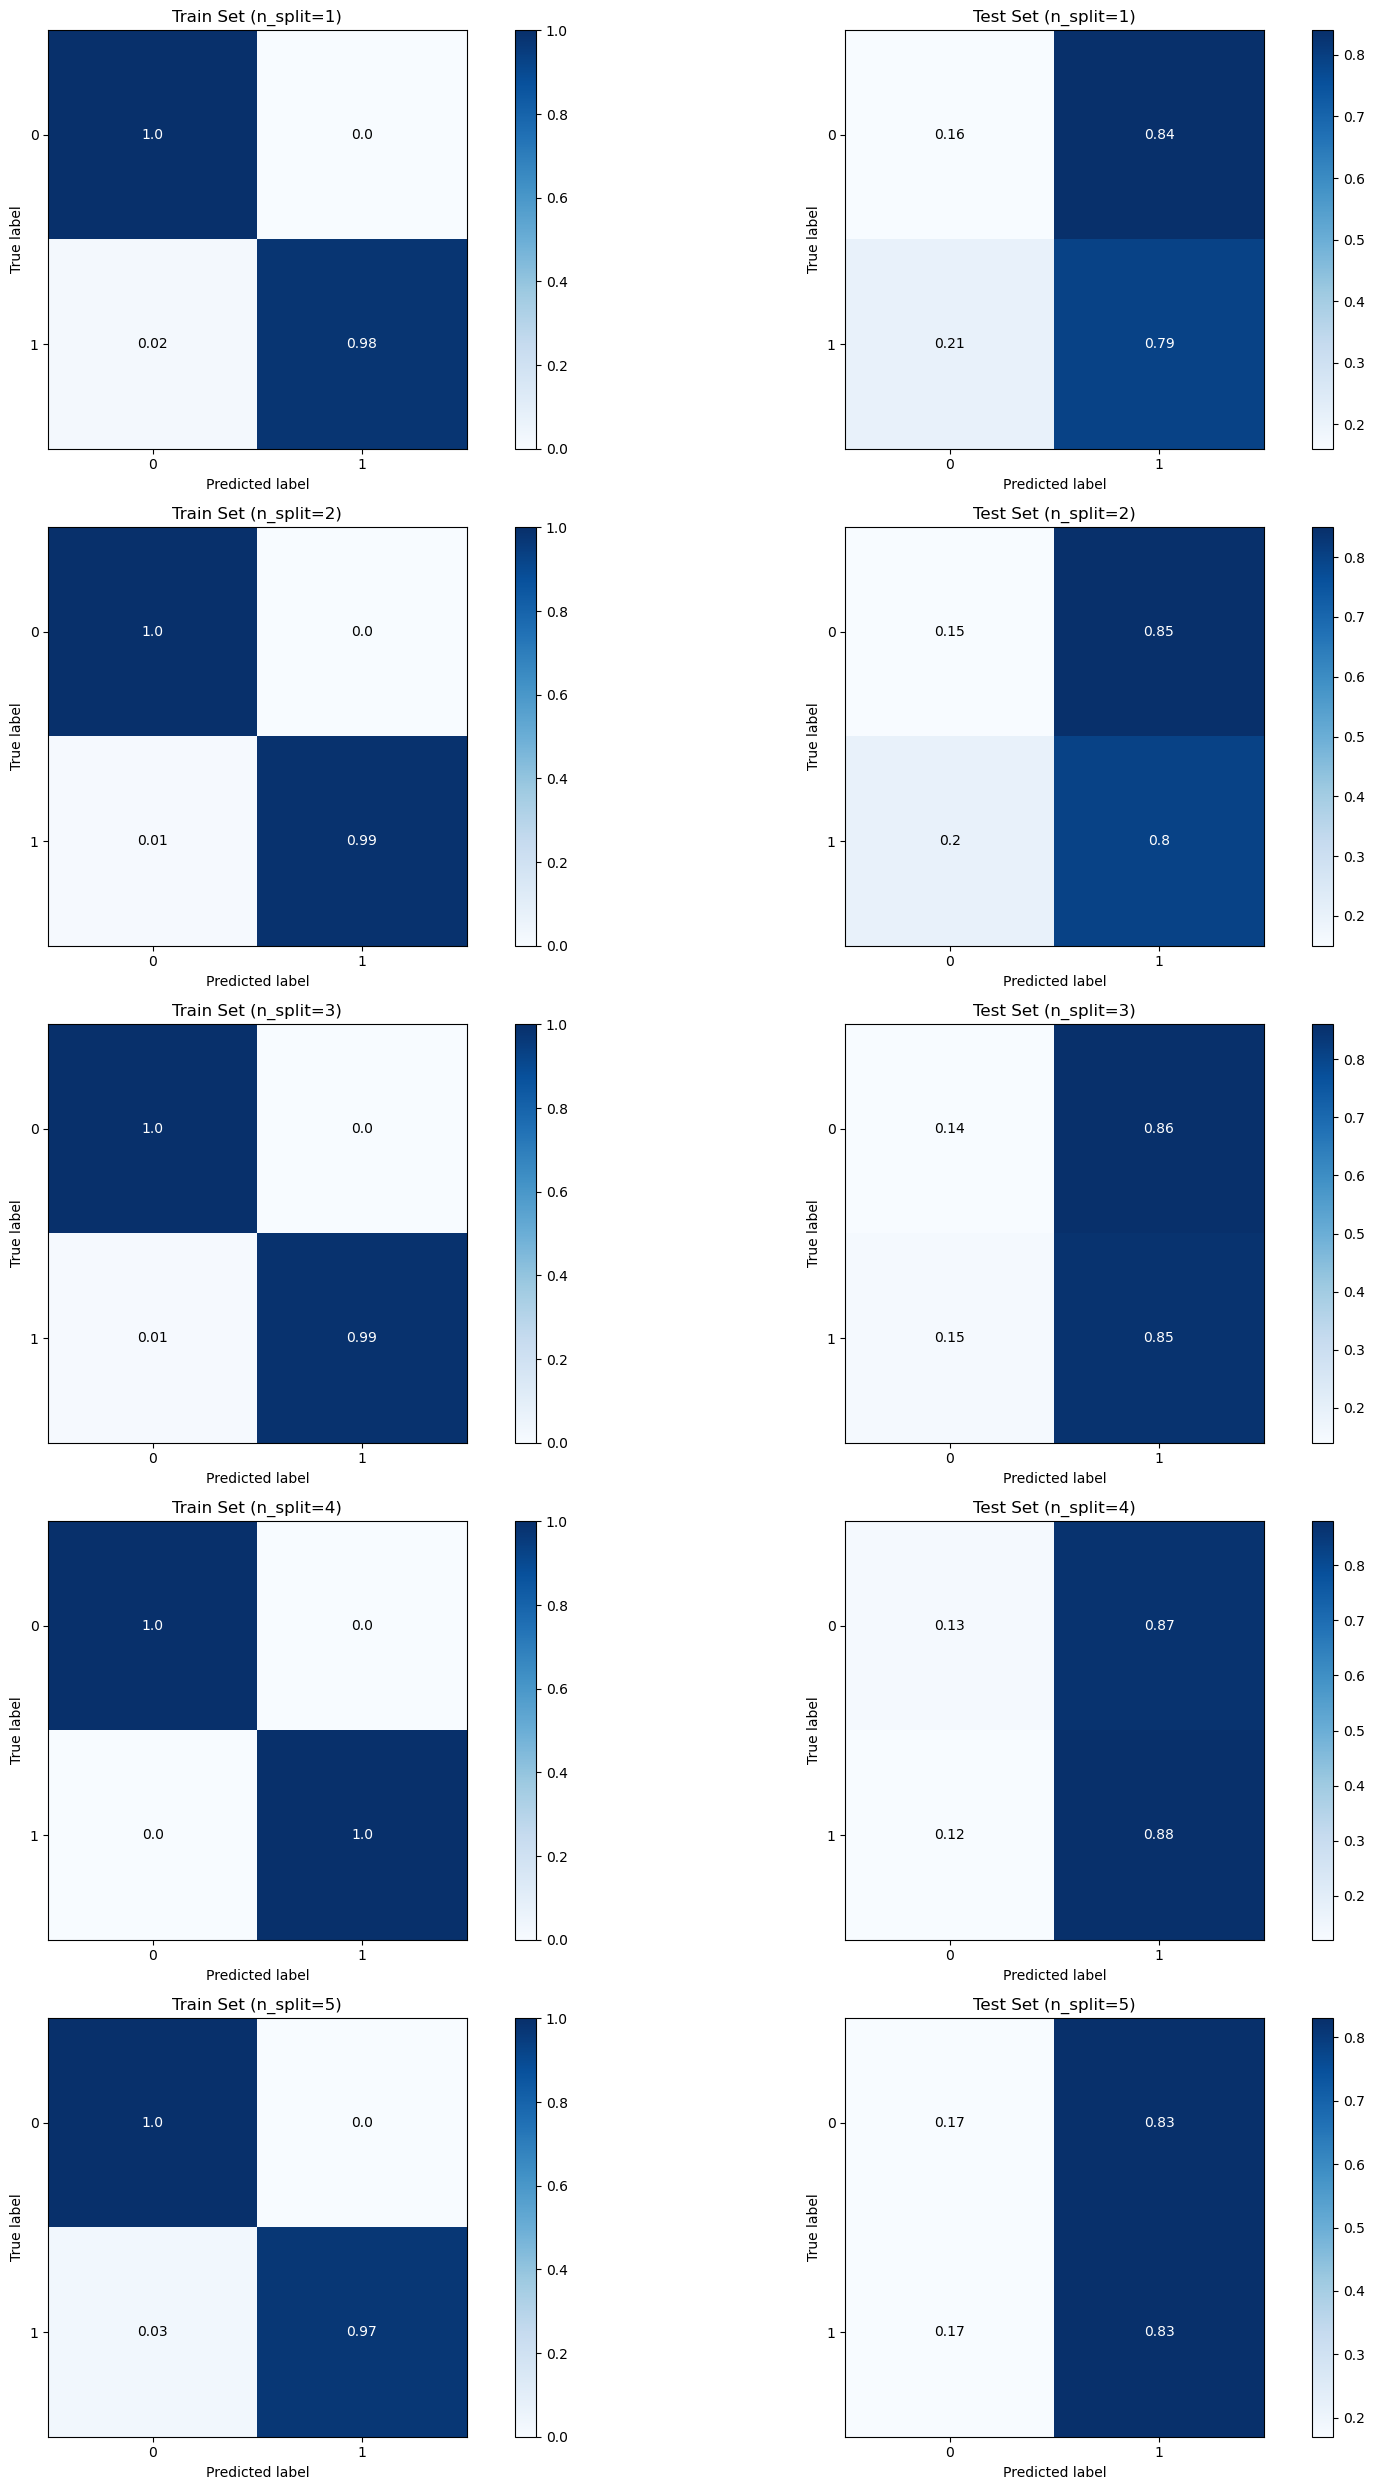

In [54]:
MyMultiTrainTester.plot_confusion(normalize=True)

In [55]:
MyMultiTrainTester.history

[None, None, None, None, None]

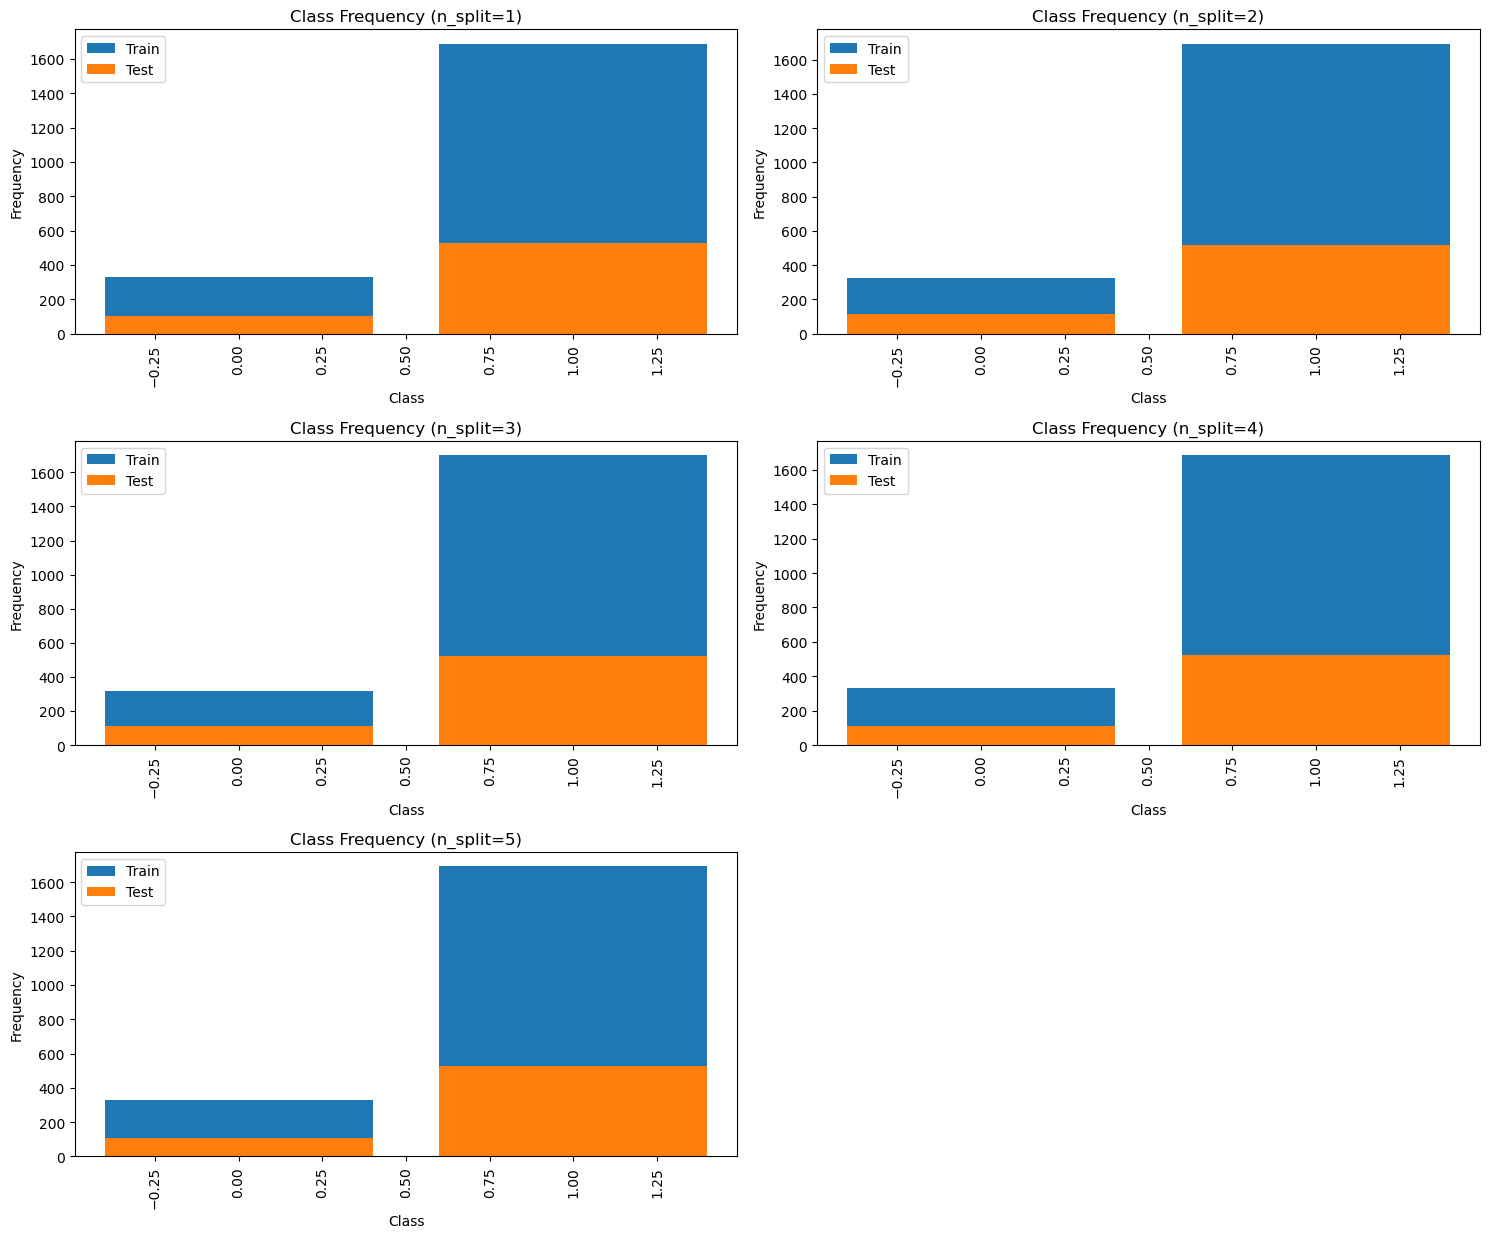

In [35]:
MyMultiTrainTester.plot_class_freq(normalize=True)

In [36]:
pd.value_counts(MyMultiTrainTester.y_train[0])

1    1687
0     330
dtype: int64

In [37]:
1721/328

5.246951219512195

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

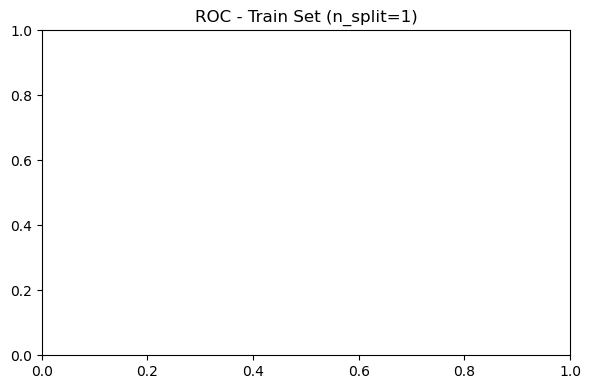

In [39]:
MyMultiTrainTester.plot_roc(figsize=(15, 25))

In [15]:
MyMultiTrainTester

array([0])